In [1]:
import os
import sys
import numpy as np

import umap.umap_ as umap

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


BASEDIR = ""
TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_short"
#TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/NC_s4r2"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
output_directory = os.path.join(image_directory, "outputs")

if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
#image_directory = ALLDIR

/home/lachlan/.pyenv/versions/3.10.6/envs/venv_xfmread/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lachlan/.pyenv/versions/3.10.6/envs/venv_xfmread/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lachlan/.pyenv/versions/

In [3]:
%load_ext autoreload
%autoreload 2

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis

FORCE_EMBED=True
FORCE_CLUST=True
OVERWRITE=True

elements, data, dims, sd_data, sd_dims = processops.compile(image_directory)

#data, dims = processops.data_crop(data, dims, 100, 500, 150, 350)

#data, elements, dims, sd_data, sd_dims = processops.compile(image_directory)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
-----------------
BEGIN reading processed data
Location: /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_short
-----
Map files found: 20
Elements identified: ['Al', 'As', 'Ca', 'Cl', 'Compton', 'Cr', 'Cu', 'Fe', 'K', 'Mn', 'Mo', 'MoL', 'Ni', 'P', 'S', 'Si', 'Ti', 'V', 'Zn', 'sum']
-----------------
READING MAP DATA
Initial shape: (393, 700, 20)
Revised shape: (392, 700, 20)
-----
-----------------
READING VARIANCE DATA
Initial shape: (197, 350, 20)
-----
Al -- data: 0.054427698254585266, var: 1.4911073446273804, ratio: 54.79222500472953
As -- data: 0.0013860455946996808, var: 0.011784680187702179, ratio: 17.00475111752093
Ca -- data: 0.0773456022143364, var: 0.055722881108522415, ratio: 1.4408803994855677
Cl -- data: 0.003481516381725669, var: 0.12431034445762634, ratio: 71.41160967107669
Compton -- data: 5.356117216415157e-10, var: 1.7024261111941996e-08, ratio: 63.56941203514703
Cr -

(80000,)
ELEMENT MAP: Si
Si, max: 3.98, 98: 3.52, avg: 0.70


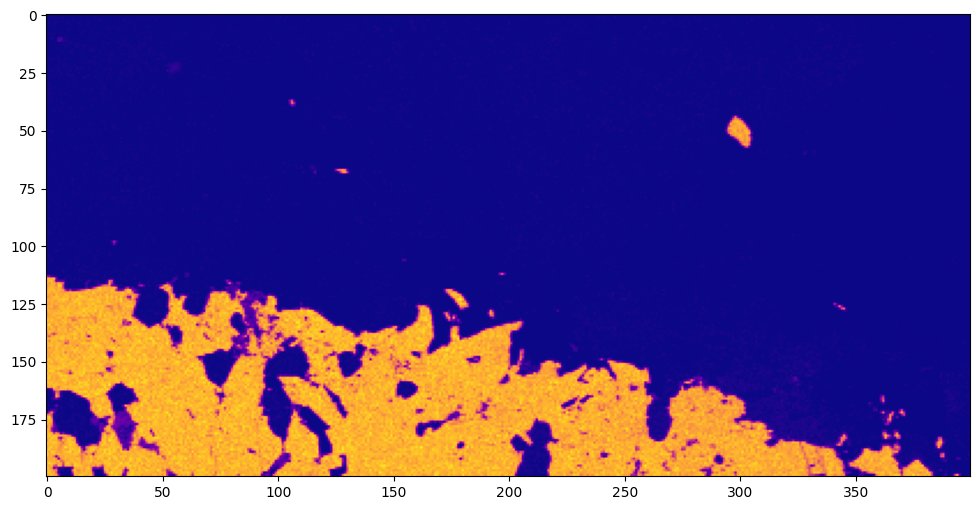

(68950,)
ELEMENT MAP: Si
Si, max: 3.58, 98: 3.47, avg: 0.98


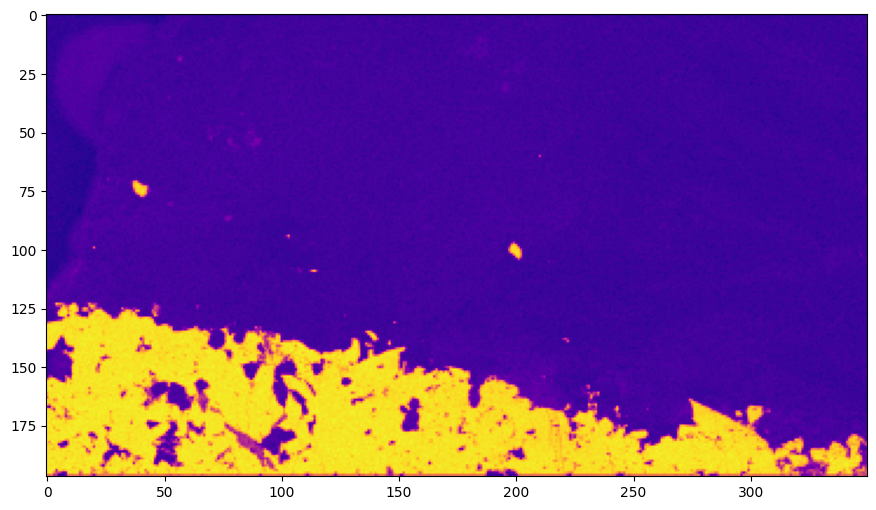

In [3]:
ELEMENT = "Si"

vis.show_map(data, dims, elements, ELEMENT)

vis.show_map(sd_data, sd_dims, elements, ELEMENT)

CALCULATING EMBED
running reducer: UMAP across data with shape: (80000, 20)
UMAP(n_components=3, n_neighbors=30, verbose=True)
Thu Jul  6 15:12:54 2023 Construct fuzzy simplicial set
Thu Jul  6 15:12:54 2023 Finding Nearest Neighbors
Thu Jul  6 15:12:54 2023 Building RP forest with 19 trees
Thu Jul  6 15:12:54 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Thu Jul  6 15:12:59 2023 Finished Nearest Neighbor Search
Thu Jul  6 15:12:59 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Jul  6 15:13:27 2023 Finished embedding
CALCULATING CATS
RUNNING CLASSIFIER
cluster 0, count: 19455
cluster 1, count: 8467
cluster 2, count: 5151
cluster 3, count: 5086
cluster 4, count: 3787
cluster 5, count: 9714
cluster 6, count: 4196
cluster 7, count: 8839
cluster 8, count: 8105
cluster 9, count: 3507
cluster 10, count: 3693
---------------------------
CLASSIFICATION COMPLETE
---------------------------
total time: 36.63 s
time per pixel: 0.000458 s
---------------------------
(80000, 3)
running reducer: PCA across data with shape: (80000, 3)
[[ 0.7245766   7.169704    8.449255  ]
 [ 8.454797    6.2963147   3.9348726 ]
 [-4.0449815   7.9356403   4.5474424 ]
 [12.178659    6.16431     8.695589  ]
 [11.968352    6.5458684  10.44392   ]
 [ 0.46397084 12.066133    8.01109   ]
 [-1.5167985  -1.0446427   7.0858054 ]
 [ 0.72184336 -0.5743381   8.3966055 ]
 [-1.4413575  10.1616535   9.32124   ]
 [ 1.9697708  10.2714205  11.197009  ]
 [ 2.870812   11.120131    9.333974  ]]
[[0.5        

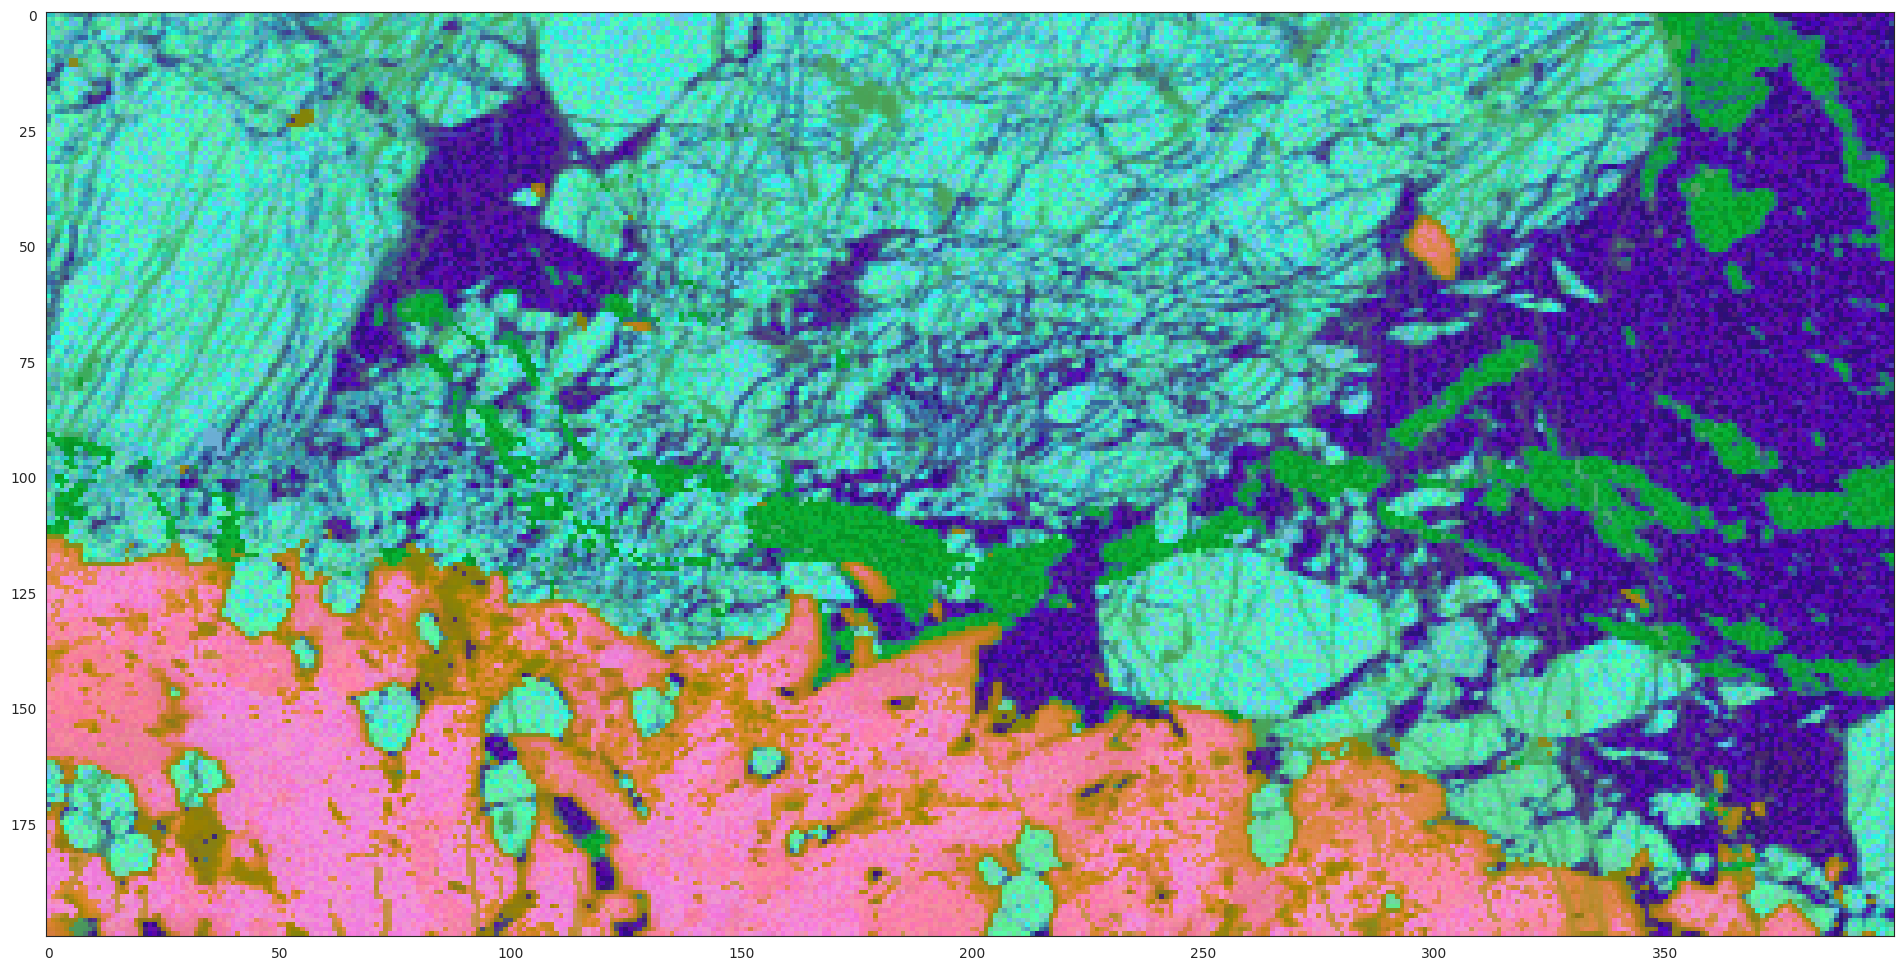

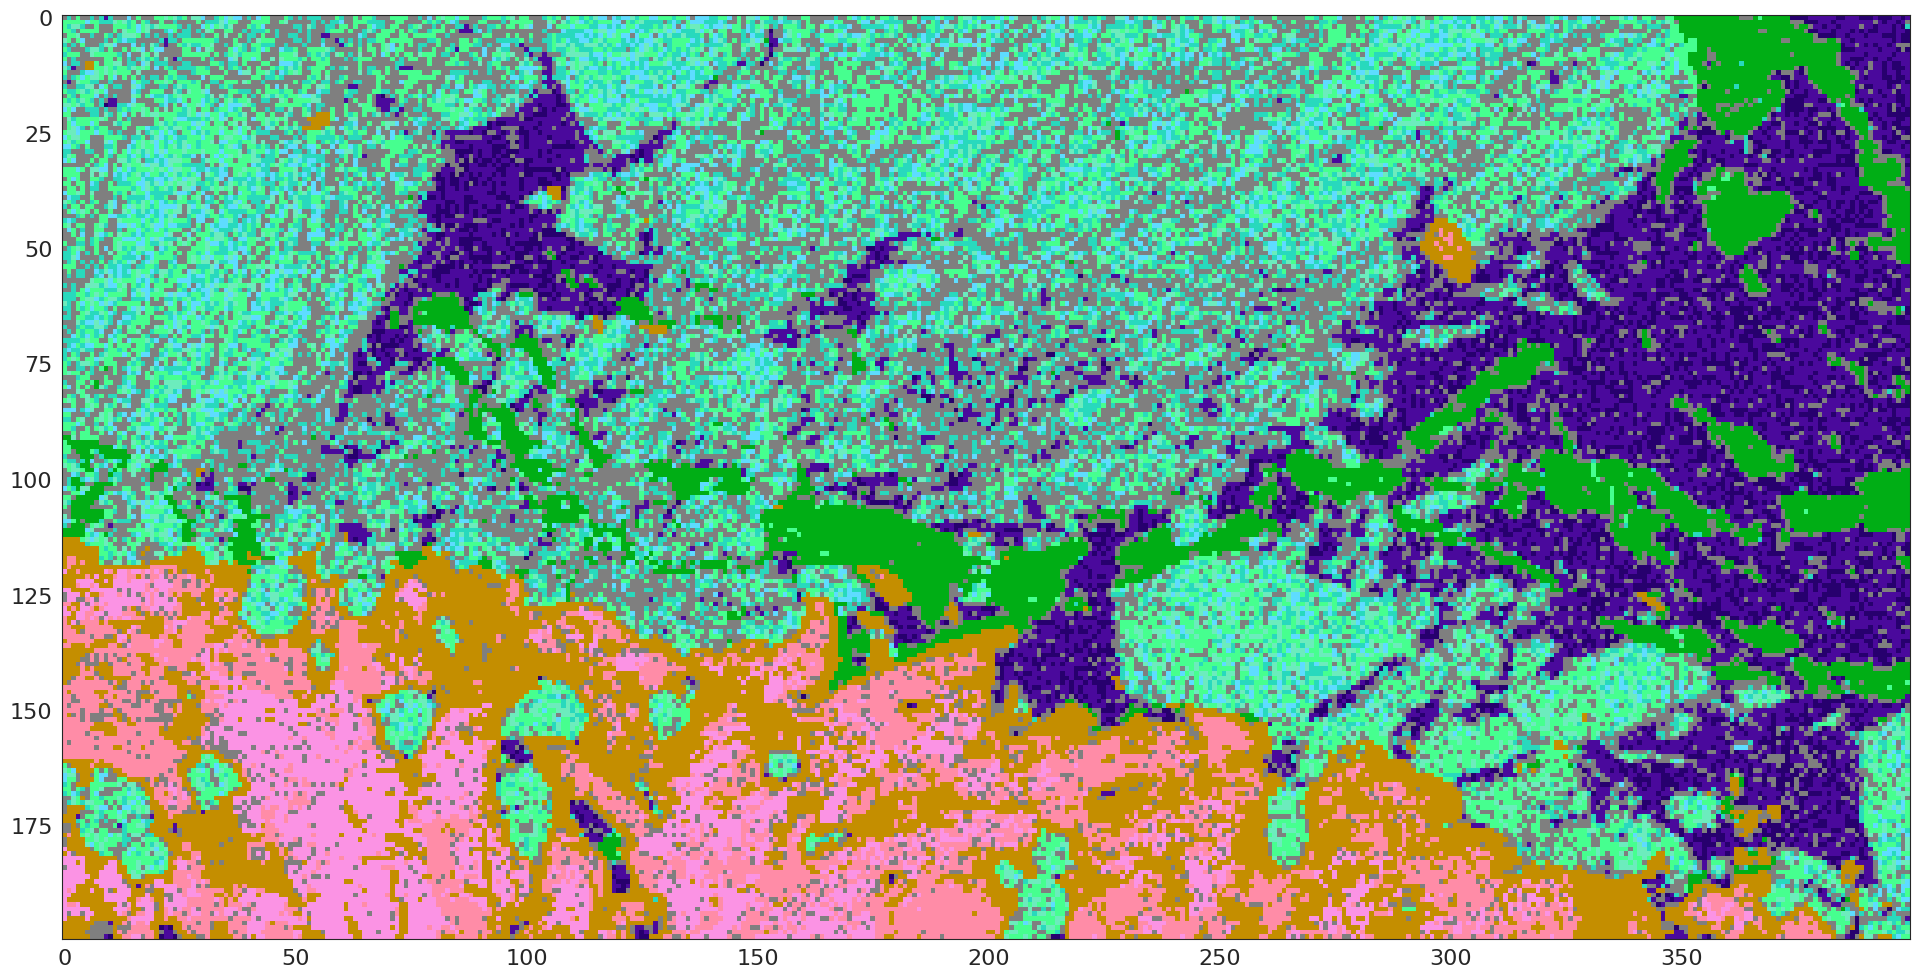

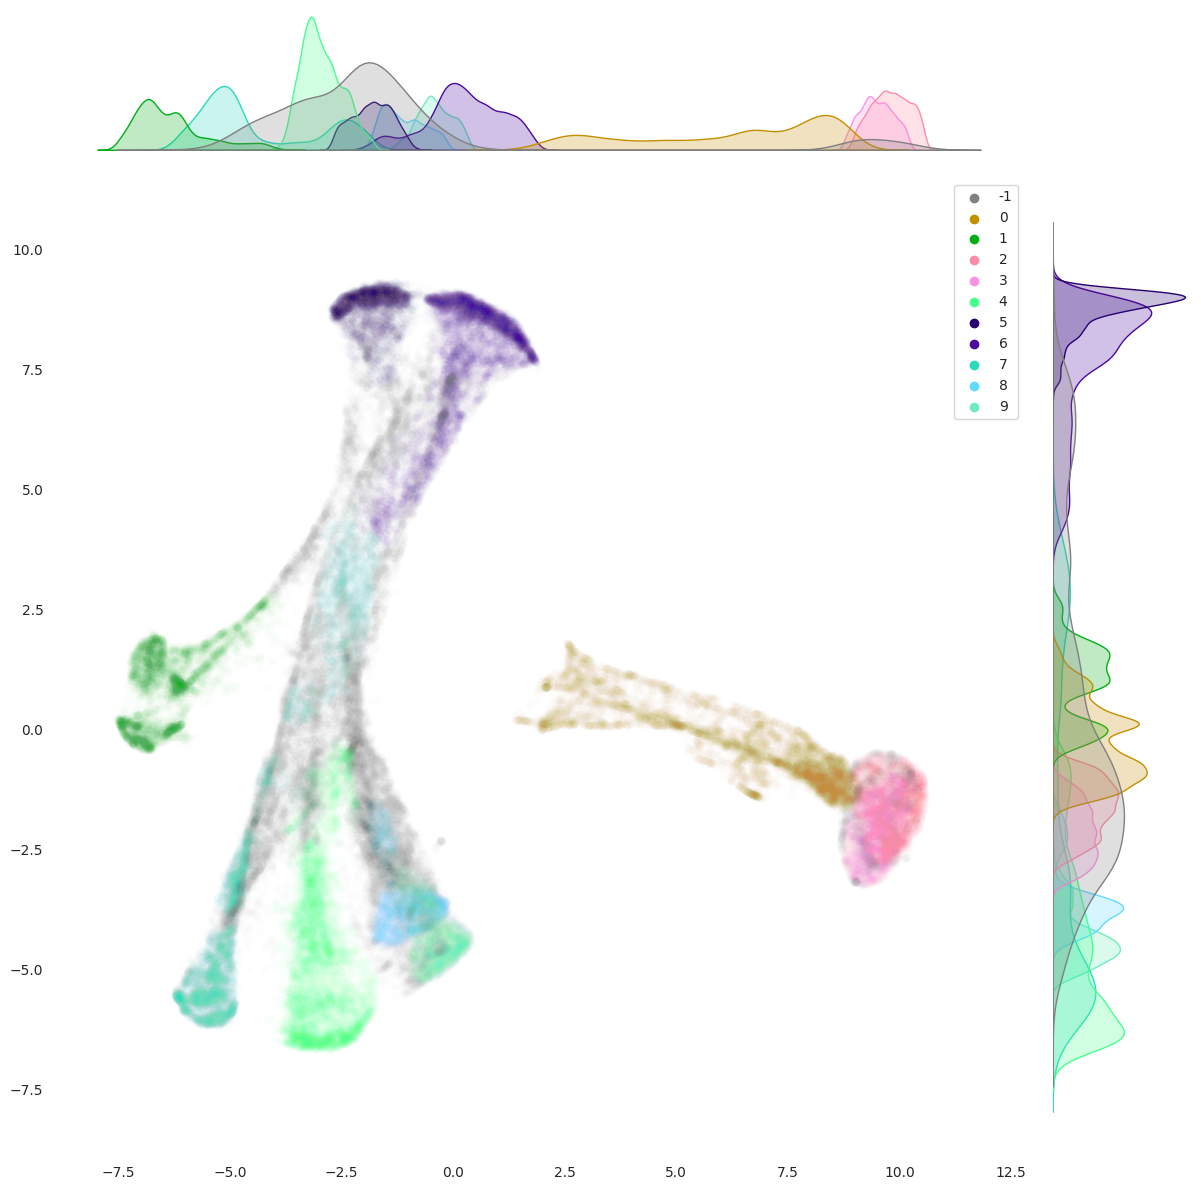

Al, max: 0.07, 98: 0.01, avg: 0.00
As, max: 0.00, 98: 0.00, avg: 0.00
Ca, max: 2.56, 98: 0.26, avg: 0.03
Cl, max: 0.00, 98: 0.00, avg: 0.00
Compton, max: 0.86, 98: 0.07, avg: 0.01
Cr, max: 0.00, 98: 0.00, avg: 0.00
Cu, max: 1.04, 98: 0.97, avg: 0.22
Fe, max: 3.34, 98: 3.13, avg: 2.00
K, max: 0.02, 98: 0.00, avg: 0.00
Mn, max: 0.26, 98: 0.02, avg: 0.01
Mo, max: 0.22, 98: 0.12, avg: 0.04
MoL, max: 0.03, 98: 0.00, avg: 0.00
Ni, max: 0.00, 98: 0.00, avg: 0.00
P, max: 0.00, 98: 0.00, avg: 0.00
S, max: 1.08, 98: 0.89, avg: 0.46
Si, max: 3.98, 98: 3.52, avg: 0.70
Ti, max: 0.02, 98: 0.00, avg: 0.00
V, max: 0.00, 98: 0.00, avg: 0.00
Zn, max: 0.43, 98: 0.03, avg: 0.00
sum, max: 0.87, 98: 0.75, avg: 0.44
CPU times: user 3min 35s, sys: 22.5 s, total: 3min 57s
Wall time: 40.9 s


In [43]:
%%time

FORCE_EMBED=False
FORCE_CLUST=True
OVERWRITE=True

categories, classavg, embedding = clustering.run(data, image_directory, sqrt=True, force_embed=FORCE_EMBED, force_clust=FORCE_CLUST, overwrite=OVERWRITE)

palette = vis.plot_clusters(categories, classavg, embedding, dims, output_directory=output_directory)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")





In [24]:
import pandas as pd
from tabulate import tabulate

elements

df = pd.DataFrame(data=classavg, columns=elements)

df
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-----------+
|    |          Al |          As |          Ca |          Cl |     Compton |          Cr |          Cu |          Fe |           K |          Mn |         Mo |         MoL |          Ni |           P |         S |          Si |          Ti |           V |          Zn |       sum |
|----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-----------|
|  0 | 0.000783072 | 7.95852e-09 | 0.00762668  | 7.95646e-05 | 0.0167615   | 0.000633282 | 0.0285418   | 3.05543     | 4.92715e-05 | 0.0080056   | 0.01953

In [8]:
import pandas as pd
from tabulate import tabulate
import xfmreadout.utils as utils

raw_data = data

def calc_classavg(dataset, categories, n_clusters, n_channels):
    """
    calculate summed spectrum for each cluster
    args: 
        dataset, spectrum by px
        catlist, categories by px
    returns:
        specsum, spectrum by category
    
    aware: nclust, number of clusters
    """
    specsum=np.zeros((n_clusters,n_channels))

    if n_clusters != utils.count_categories(categories)[0]:
        raise ValueError("cluster count mismatch")

    for i in range(np.min(categories), np.max(categories)):
        datcat=dataset[categories==i]
        print(f"cluster {i}, count: {datcat.shape[0]}") #DEBUG
        pxincat = datcat.shape[0]   #no. pixels in category i
        specsum[i,:]=(np.sum(datcat,axis=0))/pxincat
    return specsum

n_channels = data.shape[1]
n_clusters, category_list = utils.count_categories(categories)

classavg2=calc_classavg(raw_data, categories, n_clusters, n_channels) 
df = pd.DataFrame(data=classavg, columns=elements)
print(tabulate(df, headers='keys', tablefmt='psql'))




print(n_clusters)
print(category_list)
for i in category_list:
    print(i)
print(len(category_list))



cluster -1, count: 22546
cluster 0, count: 5205
cluster 1, count: 4520
cluster 2, count: 7652
cluster 3, count: 4519
cluster 4, count: 3776
cluster 5, count: 4486
cluster 6, count: 4411
cluster 7, count: 7923
cluster 8, count: 5270
+----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-----------+
|    |          Al |          As |          Ca |          Cl |     Compton |          Cr |          Cu |          Fe |           K |          Mn |         Mo |         MoL |          Ni |           P |         S |          Si |          Ti |           V |          Zn |       sum |
|----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+---

In [16]:
n_clusters = len(category_list)

for i in range(n_clusters):
    print(i)

0
1
2
3
4
5
6
7
8
9
10


(80000,)
(80000,)
(80000,)
(80000,)


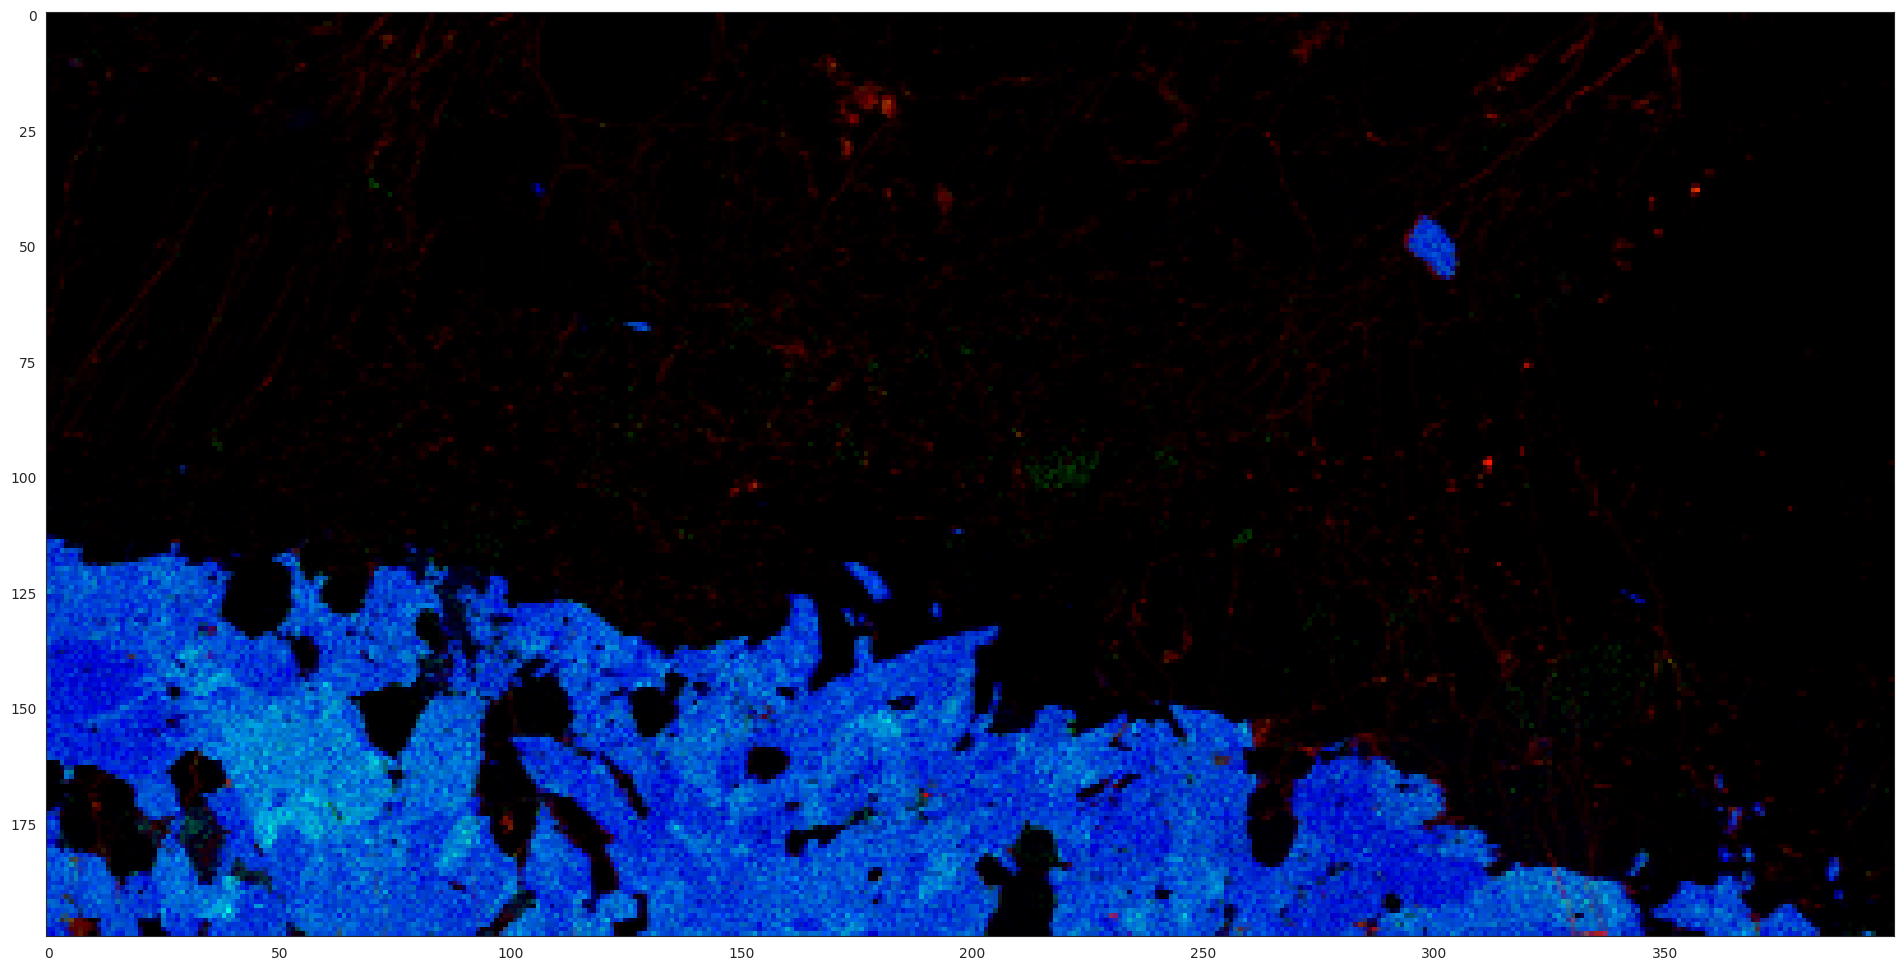

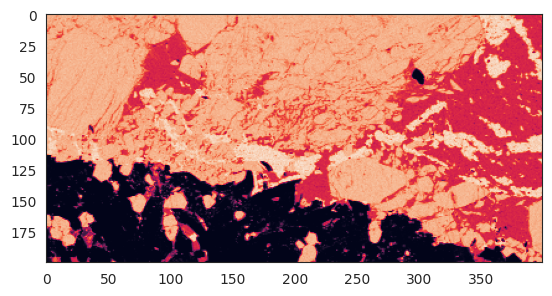

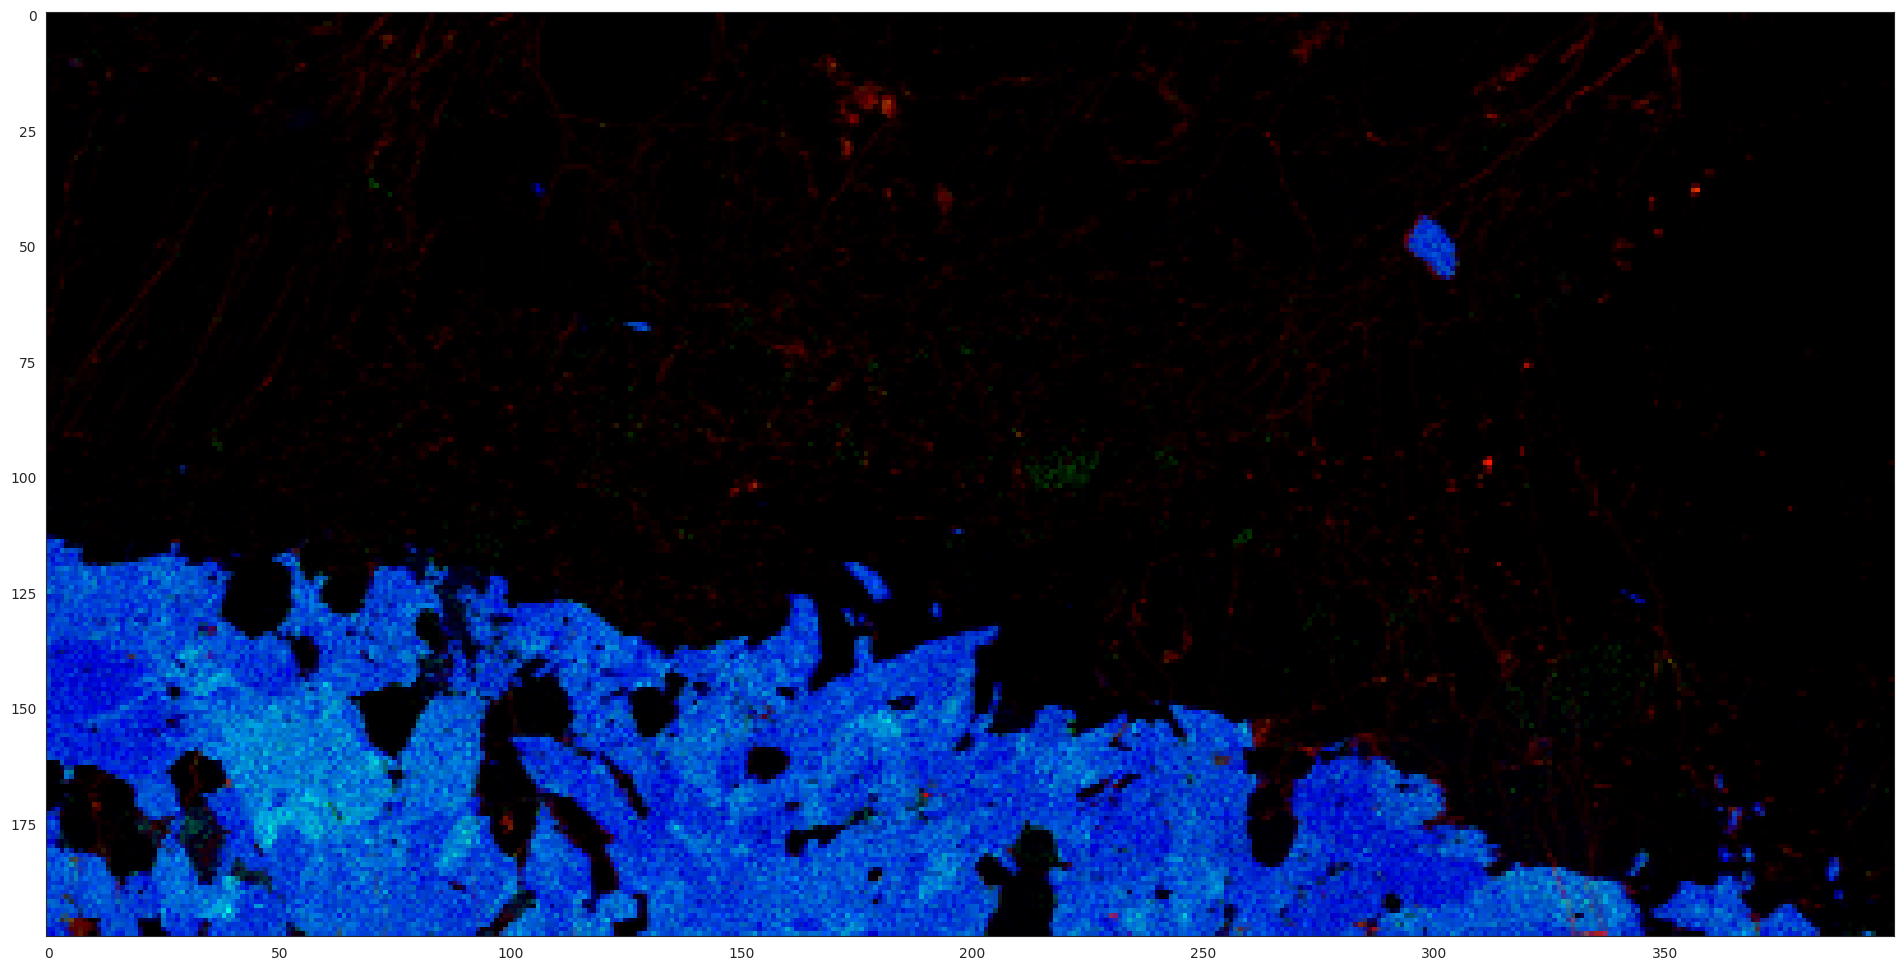

In [36]:
import xfmreadout.utils as utils
import xfmreadout.visualisations as vis

r = utils.get_map(data, dims, elements, 'Fe')
plt.imshow(r)

#vis.tricolour_enames('Fe','Cu','Si', data, dims, elements)
vis.tricolour_enames('Ca','As','Si', data, dims, elements)

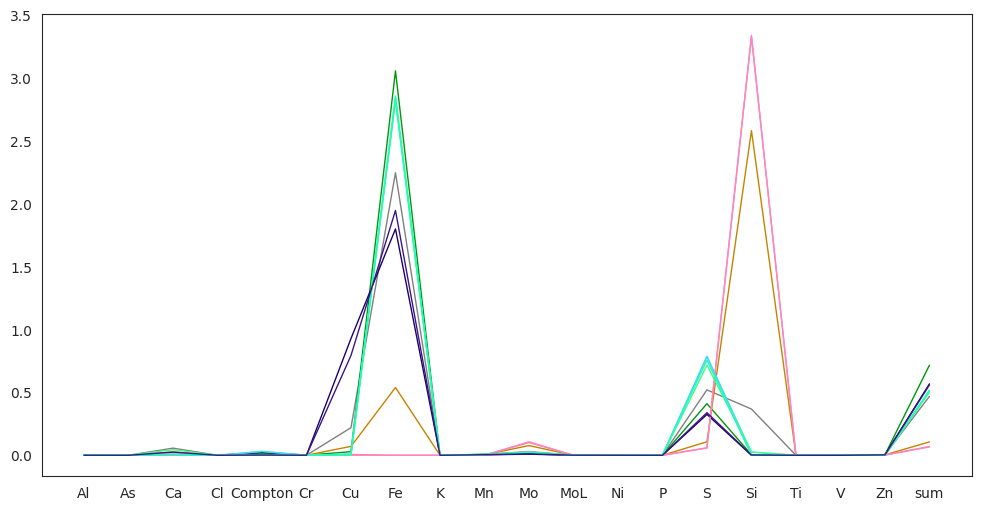

In [40]:
from matplotlib import colors

vis.category_avgs(categories, elements, classavg, palette=palette)